In [1]:
from CB_02704 import *
from functions_shashank import *
import numpy as np

In [2]:
# read the admixed population data
pop_admixed = np.load('data/simulated_genomes.npy')
# limit to chr 1
pop_admixed = pop_admixed[:55983, :]

In [3]:
pop_gen1 = read_geno_pop_chr('YRI', 1)
pop_gen2 = read_geno_pop_chr('CEU', 1)
pop_gen3 = read_geno_pop_chr('JPT', 1)
pop_gen4 = read_geno_pop_chr('ASW', 1)

In [4]:
# make the list storing information of which population each individual belongs to
population_list = ['YRI']*pop_gen1.shape[1] + ['CEU']*pop_gen2.shape[1] + ['JPT']*pop_gen3.shape[1] + ['admixed']*pop_admixed.shape[1] + ['ASW']*pop_gen4.shape[1]

In [5]:
# horizontally stack the three populations
pop_gen = np.ma.hstack([pop_gen1, pop_gen2, pop_gen3, pop_admixed, pop_gen4])

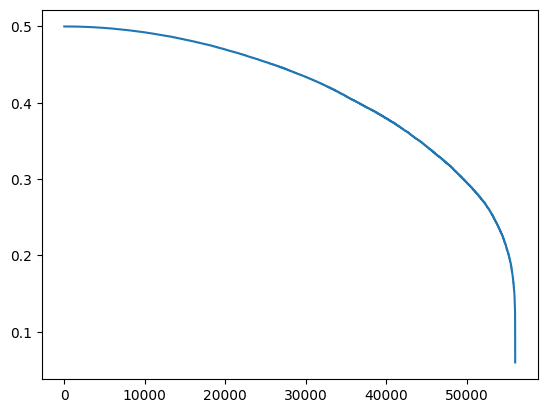

In [6]:
PlotVarianceOfFeatures(pop_gen)

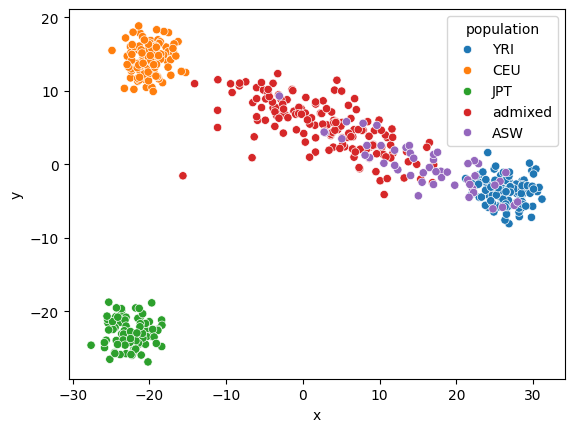

In [7]:
x_values, y_values, eigenvalues, cov = PCA(pop_gen, top_x_features=3000)
PlotPCA(x_values, y_values, population_list)

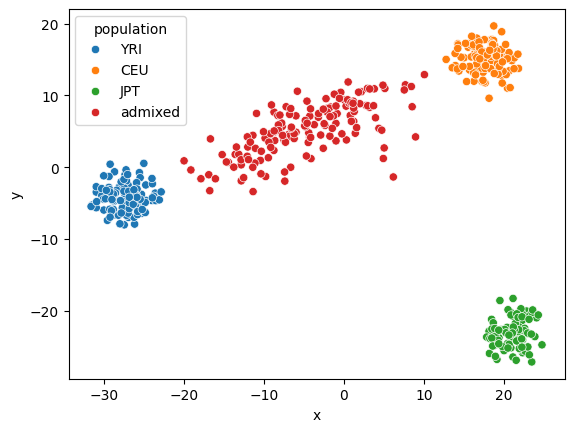

In [93]:
x_values, y_values, eigenvalues, cov = PCA(pop_gen, top_x_features=3000)
PlotPCA(x_values, y_values, population_list)

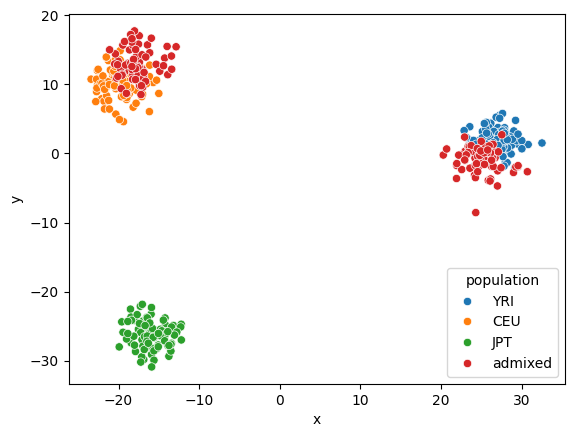

In [88]:
x_values, y_values, eigenvalues, cov = PCA(pop_gen, top_x_features=3000)
PlotPCA(x_values, y_values, population_list)